In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

import brighteyes_ism.analysis.Graph_lib as gra   #library dedicated to data plots
import brighteyes_ism.analysis.Tools_lib as tools
import brighteyes_ism.simulation.Tubulin_sim as st   #library for phantom cell simulation
import brighteyes_ism.simulation.PSF_sim as psf   #library for PSFs simulation

from s2ism import psf_estimator as est    # import library to simulate proper PSFs
from s2ism import s2ism as s2       #library containing the core functions of the algorithm


# Phantom ground truth creation
We simulate some filaments to use as a ground truth:

 30%|███       | 3/10 [00:00<00:00, 29.20it/s]

tubulin filament out of the boundaries [201.2913384] [134.20468569] 201
tubulin filament out of the boundaries [201.08113513] [70.82564309] 201
tubulin filament out of the boundaries [202.48793696] [84.69354405] 201
tubulin filament out of the boundaries [180.26759227] [201.90678876] 201
tubulin filament out of the boundaries [201.97122638] [94.96702166] 201
tubulin filament out of the boundaries [201.66530138] [82.73980585] 201


100%|██████████| 10/10 [00:00<00:00, 31.53it/s]


tubulin filament out of the boundaries [146.83899819] [201.42343672] 201
tubulin filament out of the boundaries [199.53762696] [201.38657312] 201
tubulin filament out of the boundaries [197.4363349] [-0.25532682] 201
tubulin filament out of the boundaries [138.99400142] [202.42375486] 201


  0%|          | 0/10 [00:00<?, ?it/s]

tubulin filament out of the boundaries [201.26759924] [142.0966293] 201
tubulin filament out of the boundaries [99.69599782] [201.95040494] 201
tubulin filament out of the boundaries [86.5882413] [-0.19519465] 201
tubulin filament out of the boundaries [201.1933591] [28.1372888] 201


 50%|█████     | 5/10 [00:00<00:00, 39.78it/s]

tubulin filament out of the boundaries [202.59433544] [111.90598795] 201
tubulin filament out of the boundaries [93.2137096] [202.36343216] 201
tubulin filament out of the boundaries [201.52872926] [177.01256131] 201
tubulin filament out of the boundaries [202.15359177] [115.31846533] 201
tubulin filament out of the boundaries [54.3931514] [202.26605797] 201


100%|██████████| 10/10 [00:00<00:00, 40.92it/s]


tubulin filament out of the boundaries [115.36783256] [-0.71144484] 201


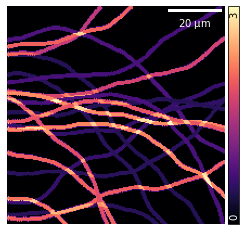

In [2]:
Nx = 201
Nz=2
pxsizex = 40

tubulin_planar = st.tubSettings()
tubulin_planar.xy_pixel_size = pxsizex
tubulin_planar.xy_dimension = Nx
tubulin_planar.xz_dimension = 1
tubulin_planar.z_pixel =  1
tubulin_planar.n_filament = 10
tubulin_planar.radius_filament = 80
tubulin_planar.intensity_filament = [0.6, 1]

phTub=np.zeros([Nz,Nx,Nx])

for i in range(Nz):
        phTub_planar= st.functionPhTub(tubulin_planar)
        phTub_planar = np.swapaxes(phTub_planar, 2, 0)
        phTub[i,:,:] = phTub_planar*(np.power(3,np.abs(i)))


phantom = gra.ShowImg(phTub.sum(axis=0), pxsize_x=pxsizex*10e-3,cmap='magma')

# PSFs simulation
We define the parameters of the microscope as attributes of the following objects:

In [3]:
exPar = psf.simSettings()
exPar.na = 1.4   # numerical aperture
exPar.wl = 640   # excitation wavelength [nm]
exPar.gamma = 45 # parameter describing the light polarization
exPar.beta = 90  # parameter describing the light polarization
exPar.n = 1.5    #refractive index of the objective medium
exPar.mask_sampl = 50  #sampling points of the phase mask in simulation

emPar = exPar.copy()
emPar.wl = 660 # emission wavelength [nm]

We calculate the optimal out-of-focus position maximizing the discrepancy of the in-focus PSFs.

Calculating the PSFs stack from z = 0.0 nm to z = 1416.0 nm:


100%|██████████| 60/60 [13:15<00:00, 13.26s/it]


Optimal out-of-focus position = 720.0 nm


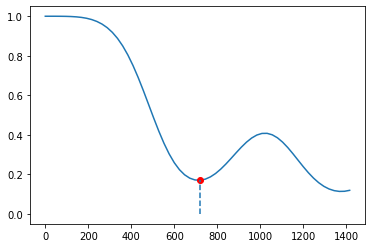

In [4]:
optimal_bkg_plane,_ = est.find_out_of_focus_from_param(pxsizex, exPar, emPar, mode = 'Pearson', stack = 'positive', graph = True)

print(f'Optimal out-of-focus position = {optimal_bkg_plane} nm')

To optimize the computation time, we set the optimal size of the simulation box with the function _psf_width_.

In [5]:
gridPar = psf.GridParameters()
gridPar.Nz = Nz
gridPar.pxsizex = pxsizex
gridPar.pxsizez = optimal_bkg_plane
gridPar.Nx = est.psf_width(gridPar.pxsizex, gridPar.pxsizez, gridPar.Nz, exPar, gridPar.spad_size())

print(f'Number of pixels in simulation = {gridPar.Nx:.2f}')

Number of pixels in simulation = 145.00


We simulate the ISM dataset of PSFs at the required planes using the parameters found before:

In [6]:
Psf, detPsf, exPsf = psf.SPAD_PSF_3D(gridPar, exPar, emPar, stack='positive')

Calculating the PSFs stack from z = 0.0 nm to z = 720.0 nm:


100%|██████████| 2/2 [00:27<00:00, 13.76s/it]


We show the in-focus PSF dataset:

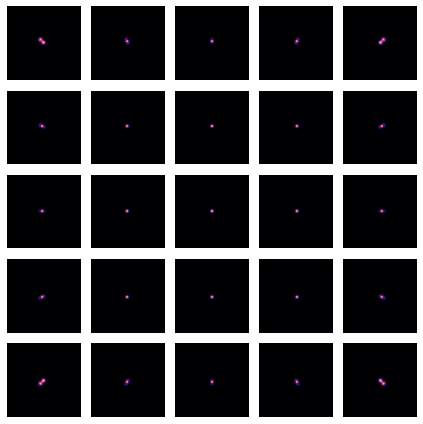

In [7]:
a = gra.ShowDataset(Psf[0], cmap ='magma')

We show the out-of-focus PSF dataset:

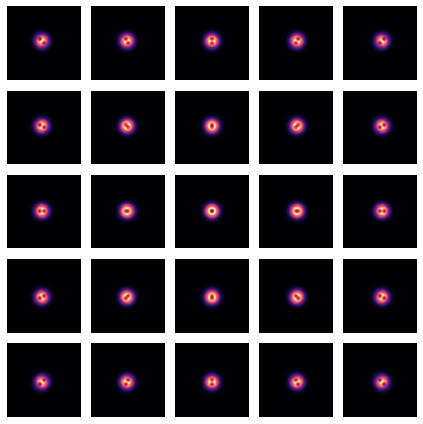

In [8]:
b = gra.ShowDataset(Psf[1],  cmap ='magma')

Now we set the SNR value for our synthetic dataset, and we normalize the PSFs:

In [9]:
N = 5
Signal = 300  #with this value we set the SNR of our phantom ISM dataset

for i in range(Nz):
    Psf[i]/=Psf[i].sum()

# Building the ISM dataset: forward model
Now that we have the PSFs, we can apply the forward model.

We can simulate the phantom ISM dataset by convolving the phantom ground truths with the respective PSFs and then corrupting the result with Poisson noise.

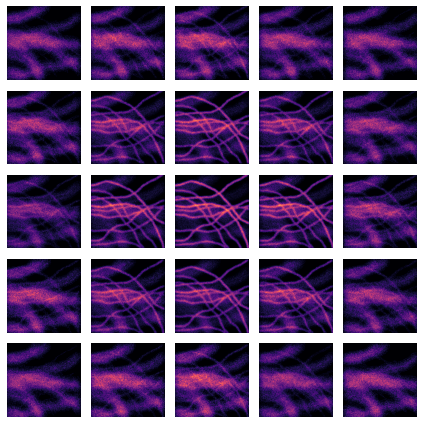

In [10]:
#we convolve the raw strands with the PSFs to simulate image system acquisition blurring

ground_truth = phTub * Signal
Nx = phTub.shape[1]
Ny = phTub.shape[2]
blurred_phantom = np.empty([Nz, Nx, Ny, N**2])

for i in range(N**2):
    for j in range(Nz):
        blurred_phantom[j, :, :, i] = convolve(ground_truth[j], Psf[j, :, :, i], mode='same')

dataset_t = np.uint16(blurred_phantom.sum(axis = 0))  # converting to photon counts
data_ISM_noise = np.random.poisson(dataset_t)         # affecting the data with Poisson noise


fig = gra.ShowDataset(data_ISM_noise, cmap ='magma')

# s$^2$ISM reconstruction
Now we launch the reconstruction.  We set _rep_to_save = 'all'_  in order to save the reconstruction at each iteration.

We can also ask the algorithm to give as output just the last iteration result (default behaviour), or to save just some of the produced estimations giving a tuple of number.

In [11]:
grid = psf.GridParameters()
grid.Nz = Nz
grid.pxsizex = pxsizex
grid.pxsizez = optimal_bkg_plane

recon_ph, photon_counts, derivative, _ = s2.max_likelihood_reconstruction(data_ISM_noise, Psf, max_iter = 50, rep_to_save ='all')

Progress: 51it [00:01, 28.11it/s]                        


The output shape is (n_iter, nz, nx, ny).

We show the result produced by the last iteration of the algorithm:

(<Figure size 432x288 with 8 Axes>,
 <AxesSubplot:label='D', title={'center':'background rejected'}>)

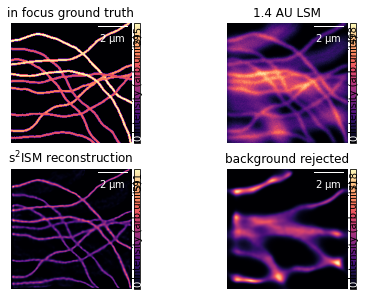

In [12]:
clabel = 'Intensity (arb.units)'
fig = plt.figure(layout="constrained")
axd =fig.subplot_mosaic(
    """
    AB
    CD
    """
)
axd["A"].set_title(r'in focus ground truth')
gra.ShowImg(ground_truth[0], pxsizex*1e-3, cmap='magma', fig = fig, ax = axd["A"], clabel =clabel)
axd["B"].set_title(r'1.4 AU LSM')
gra.ShowImg(data_ISM_noise.sum(-1),pxsizex*1e-3, cmap='magma', fig = fig, ax = axd["B"], clabel =clabel)
axd["C"].set_title(r's$^2$ISM reconstruction')
gra.ShowImg(recon_ph[-1,0], pxsizex*1e-3, cmap='magma', fig = fig, ax = axd["C"], clabel =clabel)
axd["D"].set_title(r'background rejected')
gra.ShowImg(recon_ph[-1,1], pxsizex*1e-3, cmap='magma', fig = fig, ax = axd["D"], clabel =clabel)

The algorithm conserves the total amount of photons at each iteration:

In [13]:
print(f'Reconstruction total photon counts = {recon_ph[-1].sum():.0f}')
print(f'ISM data total photon counts = {data_ISM_noise.sum():.0f}')

Reconstruction total photon counts = 5542314
ISM data total photon counts = 5542314


 We can exploit this feature to analyze the photon exchange dynamics between the two planes at each iteration.
 
The axial reassignment reaches a plateau after a few iterations:

Text(0.5, 1.0, 'photon counts derivative')

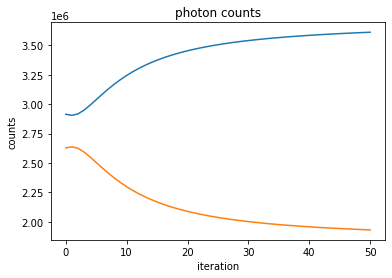

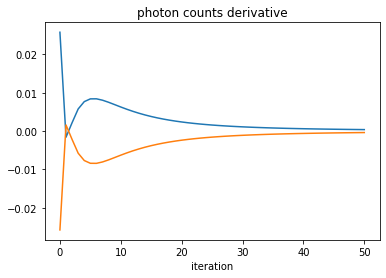

In [14]:
plt.figure()
plt.plot(photon_counts[0,:])
plt.plot(photon_counts[1,:])
plt.xlabel('iteration')
plt.ylabel('counts')
plt.title('photon counts')

plt.figure()
plt.plot(derivative[0,:])
plt.plot(derivative[1,:])
plt.xlabel('iteration')
plt.title('photon counts derivative')

# Evaluating the results
With simulataed data, we can compare the reconstruction with the ground truth at every iteration.

In [15]:
kullback_leibler = tools.kl_divergence(ground_truth, recon_ph)

The algorithm is semi-convergent. The optimal reconstruction corresponds to the one at the iteration that minimize the Kullback-Leibler divergence.

In [16]:
idx = np.argmin(kullback_leibler[1])

print(f'Optimal iteration = {idx}')

Optimal iteration = 24


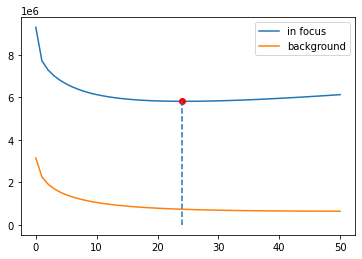

In [17]:
plt.figure()
plt.plot(kullback_leibler[1], label ='in focus')
plt.plot(idx, kullback_leibler[1][idx], 'ro')
plt.vlines(idx , 0 , kullback_leibler[1][idx], linestyles='dashed')
plt.plot(kullback_leibler[0], label ='background')
plt.legend()

Here we plot the comparison between the result produced by the optimal and last iteration

(<Figure size 432x288 with 4 Axes>,
 <AxesSubplot:label='B', title={'center':'s$^2$ISM - iteration=argmin[kl div]=24'}>)

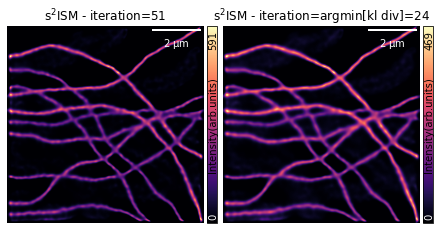

In [18]:
clabel = 'Intensity(arb.units)'
fig = plt.figure(layout="constrained")
axd =fig.subplot_mosaic(
    """
    AB

    """
)
axd["A"].set_title(f's$^2$ISM - iteration={recon_ph.shape[0]}')
gra.ShowImg(recon_ph[-1,0], pxsizex*1e-3, cmap='magma', fig = fig, ax = axd["A"], clabel =clabel)
axd["B"].set_title(f's$^2$ISM - iteration=argmin[kl div]={idx}')
gra.ShowImg(recon_ph[idx,0],pxsizex*1e-3, cmap='magma', fig = fig, ax = axd["B"], clabel =clabel)